<a href="https://colab.research.google.com/github/hridog00/RealOrNot/blob/master/ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
#! pip install "tensorflow>=1.15,<2.0"
! pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [0]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,Input, Lambda
from tensorflow.keras import regularizers, callbacks, optimizers
from tensorflow.keras.optimizers import Adam

import pandas as pd
from keras.utils import to_categorical
import keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
BASE_FOLDER = "/content/drive/My Drive/TFM/"


In [0]:
train_df = pd.read_csv(BASE_FOLDER+"/resources/data/cleaned.csv")

In [0]:
data = train_df[['cleaned_text', 'target', 'text']]
data = data.dropna()

In [0]:
X = data['cleaned_text']
y = to_categorical(data['target'].values)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## ELMO

In [0]:
embed = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [0]:


def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(embedding)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005))(dense)
    dense = Dropout(0.3)(dense)
    dense = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(dense)
    dense = Dropout(0.3)(dense)
    
    dense = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.005))(dense)
    dense = Dropout(0.3)(dense)

    pred = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    return model
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
model_elmo.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                65600     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528 

In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(X_train, y_train, epochs=50, batch_size=256, validation_split = 0.2)
    model_elmo.save_weights(BASE_FOLDER+'resources/weights/model_elmo_weights.h5')

Train on 3999 samples, validate on 1000 samples
Epoch 1/50
3999/3999 [==============================] - 19s 5ms/sample - loss: 1.6605 - acc: 0.5453 - val_loss: 1.6442 - val_acc: 0.5740
Epoch 2/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.6324 - acc: 0.5596 - val_loss: 1.6122 - val_acc: 0.5790
Epoch 3/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.5980 - acc: 0.5909 - val_loss: 1.5789 - val_acc: 0.6190
Epoch 4/50
3999/3999 [==============================] - 18s 4ms/sample - loss: 1.5682 - acc: 0.6129 - val_loss: 1.5422 - val_acc: 0.6600
Epoch 5/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.5327 - acc: 0.6097 - val_loss: 1.5054 - val_acc: 0.6790
Epoch 6/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.5044 - acc: 0.6272 - val_loss: 1.4710 - val_acc: 0.7160
Epoch 7/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.4696 - acc: 0.6437 - val_loss: 1.4357 - val_acc: 

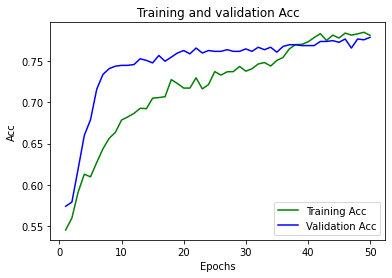

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

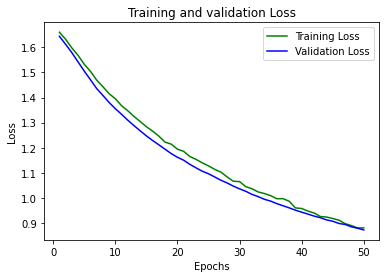

In [0]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo = build_model() 
    model_elmo.load_weights(BASE_FOLDER+'resources/weights/model_elmo_weights.h5')
    import time
    t = time.time()
    results = model_elmo.evaluate(X_test, y_test)
    print("time: ", time.time() - t)
    print(results)
    y_pred = model_elmo.predict(X_test)
    model_elmo.save(BASE_FOLDER+'elmo')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2463/2463 [==============================] - 15s 6ms/sample - loss: 0.8622 - acc: 0.7909
time:  15.764042615890503
[0.8622151023481031, 0.7909054]


In [0]:
y_pred 

array([[0.908124  , 0.09187599],
       [0.31325257, 0.6867475 ],
       [0.38988155, 0.61011845],
       ...,
       [0.66394293, 0.3360571 ],
       [0.2641687 , 0.7358313 ],
       [0.7637969 , 0.2362031 ]], dtype=float32)

In [0]:
import numpy as np

y_pred_ev = [np.argmax(y) for y in y_pred]
y_test_ev = [np.argmax(y) for y in y_test]

In [0]:
import seaborn as sns


def show_confusion_matrix(Y_GT, Y_predicted, labels=[0,1]):
    """ Pinta la matriz de confusión para dos vectores de classes. El primero es el Ground Truth. 
    """
    data = {'y_Predicted': Y_predicted,
            'y_Actual':    Y_GT
            } # Almacena los datos en un diccionario para crear el dataframe
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted']) #Construye el dataframe con una columna para el GT y otra para la predicción
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted']) #Crea una tabla que indica cuantos items del segundo parámetro hay en cada item del primero
    #plt.figure(figsize=(10, 10))
    ax = sns.heatmap(confusion_matrix, annot=True,fmt='d', cbar=False,xticklabels=labels, yticklabels=labels)
    plt.show()

In [0]:
from sklearn import metrics
def evaluate(y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    au = metrics.roc_auc_score(y_test, y_pred)
    results = pd.DataFrame({'accuracy':acc, 'f score':f1, 'ROC area':au}, index=[0])
    show_confusion_matrix(y_test, y_pred)
    display(results)

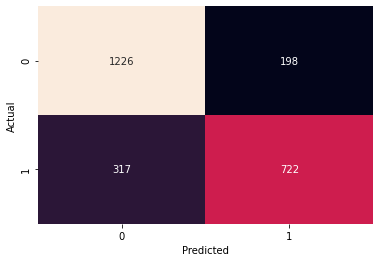

,accuracy,f score,ROC area
0,0.790905,0.737111,0.777927


In [0]:
evaluate(y_test_ev, y_pred_ev)

In [0]:
model_elmo.save(BASE_FOLDER+'elmo')

RuntimeError: ignored